In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from math import *
from scipy.interpolate import griddata
import math

In [2]:
npzfile = np.load("arduino_image.npz")
npzfile.files
Image = npzfile["Small"]
NbLines, LenLines = np.shape(Image)
#np.savez("arduino_image", Small=Small)
Image[4] = Image[5]
Image[167] = Image[168]
Raw = Image/25

In [8]:
OffSets = []
for l in range(NbLines):
    Corr = signal.correlate(Raw[0][0:250], Raw[l][0:250], mode='same') 
    ACorr = np.argmax(Corr) #
    OffSets.append((ACorr))
OffMax = max(OffSets) 


## Size

* Without decimation, we have on line the right gabarit. We find that resolution is 14.93 px / mm. That's around 15px / mm. 

* The speed of sound is 1500m/s, so on the image we have 1.332us/mm.
* Acquisition speed is therefore 14.93/1.332 is 11.2Msps.
* The acquarium wall is at 100mm, that should be 1493px

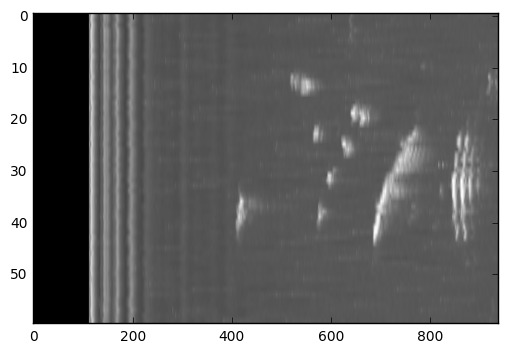

In [19]:
Decimation = 3 
DecSL = 2
NotCentered = 224

Corrected = np.zeros((NbLines, LenLines-OffMax+NotCentered))
RawImage = np.zeros((NbLines/Decimation, LenLines-OffMax+NotCentered))

NbLinesC, LenLinesC = np.shape(RawImage)

for i in range(NbLines):
    for j in range(LenLines-OffMax):
        Corrected [i][j+NotCentered] = Image[i][j-OffSets[i]+OffMax]
Corrected[97] = Corrected[96]
Corrected = Corrected-np.amin(Corrected)
Corrected = np.sqrt(Corrected)


for j in range(NbLines/Decimation):
    for k in range(Decimation):
        RawImage [j] += Corrected[Decimation*j+k]
        
RawImg = np.zeros((NbLines/Decimation, (LenLines-OffMax)/DecSL))

for i in range(NbLines/Decimation):
    for j in range((LenLines-OffMax)/DecSL):
        for k in range(DecSL):
            RawImg [i][j] += RawImage[i][DecSL*j+k]
        
plt.imshow((RawImg),cmap=plt.get_cmap('gray'),aspect='auto',)
plt.show()

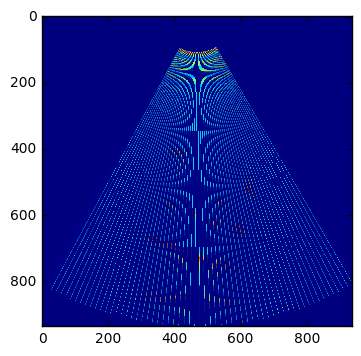

In [20]:
LenLinesC = (LenLines-OffMax)/DecSL

SC = np.zeros((LenLinesC,LenLinesC))
SC += 1
maxAngle = 60.0
step = maxAngle/(NbLinesC+1)
CosAngle = math.cos(math.radians(30))
Limit = LenLinesC*CosAngle

points = []
values = []

for i in range(LenLinesC):
    for j in range(LenLinesC):
        if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
            SC[i][j] = 0
            points.append([i,j])
            values.append(0)
        if (  (i > Limit) ):
            if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                SC[i][j] = 0 
                points.append([i,j])
                values.append(0)
for i in range(NbLinesC):
    PointAngle = i*step-30
    COS = math.cos(math.radians(PointAngle))
    SIN = math.sin(math.radians(PointAngle))
    for j in range(LenLinesC):

        X = (int)( j*COS)
        Y = (int)(LenLinesC/2 - j*SIN)
        SC[X][Y] = RawImg[i][j]
        points.append([X,Y])
        values.append(RawImg[i][j])
        
values = np.array(values,dtype=np.int)

plt.imshow((SC) )
plt.show()

In [21]:
grid_x, grid_y = np.mgrid[0:(LenLines-OffMax)/DecSL:1, 0:(LenLines-OffMax)/DecSL:1]

In [22]:
#grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
#grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

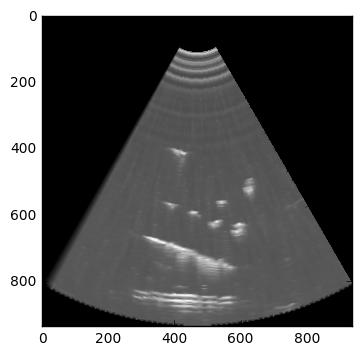

In [23]:
fig = plt.figure()
plt.imshow(grid_z1,cmap=plt.get_cmap('gray'))
plt.show()

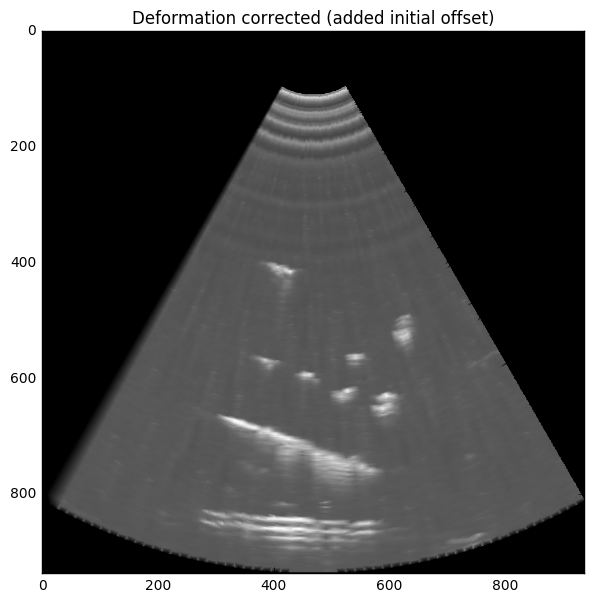

In [24]:
fig2 = plt.figure(figsize = (7,7)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(grid_z1,cmap=plt.get_cmap('gray'))
ax3.set_title('Deformation corrected (added initial offset)')

plt.show()